In [3]:
import json
import dotenv
from fastcore.all import Path
import os
from collections import defaultdict
import numpy as np
import pandas as pd

dotenv.load_dotenv()

RESULTS_DIR = Path(os.getenv("RESULTS_DIR"))
dataset_names = ["bookcorpus", "pile", "wikitext"]
model_names = [
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Meta-Llama-3.1-8B",
]
num_partitions = 5

# Modified nested defaultdict structure to handle model dimension
results = defaultdict(
    lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
)

# Collect results across partitions
for shuffled in ["", "_shuffled"]:
    for model_name in model_names:
        for dataset_name in dataset_names:
            for partition in range(num_partitions):
                try:
                    results_file = (
                        RESULTS_DIR
                        / f"{model_name}_{dataset_name}_{partition}{shuffled}.json"
                    )
                    results_current = Path.read_json(results_file)
                    # Add each layer's intrinsic dimension to results
                    shuffled_state = (
                        "shuffled" if shuffled == "_shuffled" else "unshuffled"
                    )
                    for layer, id_value in results_current[
                        "intrinsic_dimensions"
                    ].items():
                        results[model_name][dataset_name][layer][shuffled_state].append(
                            id_value
                        )
                except Exception as e:
                    print(f"Error reading {results_file}: {e}")

# Create DataFrame
rows = []
for model_name in model_names:
    for dataset_name in dataset_names:
        for layer in results[model_name][dataset_name]:
            for shuffled_state in ["shuffled", "unshuffled"]:
                values = np.array(
                    results[model_name][dataset_name][layer][shuffled_state]
                )
                if len(values) > 0:  # Only add if we have values for this combination
                    rows.append({
                        "model_name": model_name,
                        "dataset_name": dataset_name,
                        "layer": int(layer),
                        "shuffled": shuffled_state == "shuffled",
                        "intrinsic_dimension_mean": np.mean(values),
                        "intrinsic_dimension_std": np.std(values),
                    })

df = pd.DataFrame(rows)
df = df.sort_values(["model_name", "dataset_name", "layer", "shuffled"])
df

Error reading /share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_0.json: [Errno 2] No such file or directory: '/share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_0.json'
Error reading /share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_1.json: [Errno 2] No such file or directory: '/share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_1.json'
Error reading /share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_2.json: [Errno 2] No such file or directory: '/share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_2.json'
Error reading /share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_3.json: [Errno 2] No such file or directory: '/share/u/lofty/representations-across-sizes/results/meta-llama/Llama-3.2-1B_pile_3.json'
Error reading /share/u/lofty/representations-across-sizes/results/meta-llama/Lla

,model_name,dataset_name,layer,shuffled,intrinsic_dimension_mean,intrinsic_dimension_std
1,meta-llama/Llama-3.2-1B,bookcorpus,0,False,8.341114,0.056641
0,meta-llama/Llama-3.2-1B,bookcorpus,0,True,9.388634,0.051501
3,meta-llama/Llama-3.2-1B,bookcorpus,1,False,12.320829,0.025780
2,meta-llama/Llama-3.2-1B,bookcorpus,1,True,13.461572,0.079533
5,meta-llama/Llama-3.2-1B,bookcorpus,2,False,13.851970,0.024401
...,...,...,...,...,...,...
114,meta-llama/Llama-3.2-3B,bookcorpus,25,True,20.531612,0.102700
117,meta-llama/Llama-3.2-3B,bookcorpus,26,False,19.644770,0.013025
116,meta-llama/Llama-3.2-3B,bookcorpus,26,True,21.832525,0.084993
119,meta-llama/Llama-3.2-3B,bookcorpus,27,False,19.530453,0.054810


In [4]:
df.groupby("model_name").layer.max()

model_name
meta-llama/Llama-3.2-1B    15
meta-llama/Llama-3.2-3B    27
Name: layer, dtype: int64

In [5]:
model_layers = {
    "meta-llama/Llama-3.2-1B": 16,
    "meta-llama/Llama-3.2-3B": 28,
    "meta-llama/Meta-Llama-3.1-8B": 32,
}
df["proportion"] = df.apply(
    lambda row: row["layer"] / (model_layers[row["model_name"]] - 1), axis=1
)
df

,model_name,dataset_name,layer,shuffled,intrinsic_dimension_mean,intrinsic_dimension_std,proportion
1,meta-llama/Llama-3.2-1B,bookcorpus,0,False,8.341114,0.056641,0.000000
0,meta-llama/Llama-3.2-1B,bookcorpus,0,True,9.388634,0.051501,0.000000
3,meta-llama/Llama-3.2-1B,bookcorpus,1,False,12.320829,0.025780,0.066667
2,meta-llama/Llama-3.2-1B,bookcorpus,1,True,13.461572,0.079533,0.066667
5,meta-llama/Llama-3.2-1B,bookcorpus,2,False,13.851970,0.024401,0.133333
...,...,...,...,...,...,...,...
114,meta-llama/Llama-3.2-3B,bookcorpus,25,True,20.531612,0.102700,0.925926
117,meta-llama/Llama-3.2-3B,bookcorpus,26,False,19.644770,0.013025,0.962963
116,meta-llama/Llama-3.2-3B,bookcorpus,26,True,21.832525,0.084993,0.962963
119,meta-llama/Llama-3.2-3B,bookcorpus,27,False,19.530453,0.054810,1.000000


In [6]:
df.groupby("model_name").proportion.max()

model_name
meta-llama/Llama-3.2-1B    1.0
meta-llama/Llama-3.2-3B    1.0
Name: proportion, dtype: float64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the dataframe is called df

# Extract the model size from the model_name column
# For example, if model_name is "meta-llama/Llama-3.2-1B"
# we just want "Llama-3.2-1B"
df["model_size"] = df["model_name"].apply(lambda x: x.split("/")[-1])


In [8]:
# Calculate mean over datasets for each model and layer
df_mean = (
    df.groupby(["model_size", "proportion", "shuffled"])[
        ["intrinsic_dimension_mean", "intrinsic_dimension_std"]
    ]
    .mean()
    .reset_index()
)

df_mean

,model_size,proportion,shuffled,intrinsic_dimension_mean,intrinsic_dimension_std
0,Llama-3.2-1B,0.000000,False,9.032085,0.044442
1,Llama-3.2-1B,0.000000,True,9.906859,0.043253
2,Llama-3.2-1B,0.066667,False,13.091351,0.057412
3,Llama-3.2-1B,0.066667,True,13.854795,0.069412
4,Llama-3.2-1B,0.133333,False,14.679013,0.034029
...,...,...,...,...,...
83,Llama-3.2-3B,0.925926,True,20.531612,0.102700
84,Llama-3.2-3B,0.962963,False,19.644770,0.013025
85,Llama-3.2-3B,0.962963,True,21.832525,0.084993
86,Llama-3.2-3B,1.000000,False,19.530453,0.054810


In [11]:
df_mean

,model_size,proportion,shuffled,intrinsic_dimension_mean,intrinsic_dimension_std
0,Llama-3.2-1B,0.000000,False,9.032085,0.044442
1,Llama-3.2-1B,0.000000,True,9.906859,0.043253
2,Llama-3.2-1B,0.066667,False,13.091351,0.057412
3,Llama-3.2-1B,0.066667,True,13.854795,0.069412
4,Llama-3.2-1B,0.133333,False,14.679013,0.034029
...,...,...,...,...,...
83,Llama-3.2-3B,0.925926,True,20.531612,0.102700
84,Llama-3.2-3B,0.962963,False,19.644770,0.013025
85,Llama-3.2-3B,0.962963,True,21.832525,0.084993
86,Llama-3.2-3B,1.000000,False,19.530453,0.054810


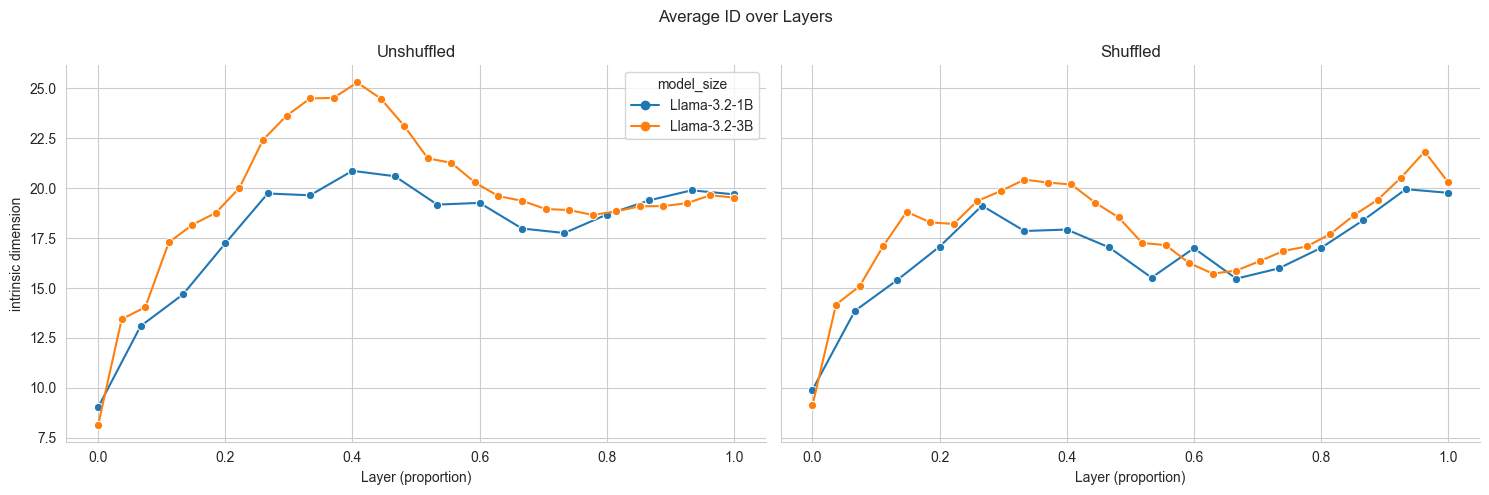

In [16]:
import seaborn as sns

sns.set_style("whitegrid")
g = sns.relplot(
    data=df_mean,
    x="proportion",
    y="intrinsic_dimension_mean",
    hue="model_size",
    col="shuffled",
    marker="o",
    kind="line",
    aspect=1.5,
    legend="brief",
    facet_kws={
        "legend_out": False,
    },
)
g.legend.set_bbox_to_anchor((1, 1))
g.set_xlabels("Layer (proportion)")
g.set_ylabels("intrinsic dimension")

# Set column labels
g.axes[0, 0].set_title("Unshuffled")
g.axes[0, 1].set_title("Shuffled")

plt.suptitle("Average ID over Layers")
plt.tight_layout()
plt.show()
